# Project-3. Прогнозирование рейтинга отеля на Booking

**Цель:** создать модель, которая должна предсказывать рейтинг отеля по данным сайта Booking на основе имеющихся в датасете данных.

## Загружаем библиотеки и инструменты

In [8]:
# Импорт стандартных библиотек

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math

# Импорт библиотек для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
# для настройки шага сетки
from matplotlib import ticker

# Импорт библиотек для кодирования
import category_encoders as ce

# Для работы с регулярными выражениями
import re

# Загрузка специального инструмента для удобного разделения датасетов
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Воспроизводимость кода

In [9]:
# Фиксируем сид для воспроизводимости кода
RANDOM_SEED = 42

In [10]:
# Фиксируем версии пакетов для воспроизводимости кода
!pip freeze > requirements.txt

## Загружаем данные из соревнования

In [11]:
df_train = pd.read_csv('data/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv('data/hotels_test.csv') # датасет для тестирования
sample_submission = pd.read_csv('data/submission.csv') # submission

## Предварительное исследование данных

Посмотрим какие данные имеются в датасете, сколько пустых значений в признаках и какие типы данных.

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [13]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [14]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

Как видим в тренировочном датасете на один признак больше, так как для тестового нам как раз нужно будет предсказать reviewer_score. Числовых признаков (без учета признака оценки рецензента) в датасетах 8. Есть признаки days_since_review и review_date, которые на данный момент имеют тип object, и которые можно преобразовать к типу datetime. Остальные признаки строковые. Также можно увидеть что два числовых признака имеют большое количество пустых значений. Посмотрим какую информацию можно вывести из нечисловых признаков и какой вид они имеют (есть ли структура или это просто текст).

In [15]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


Адрес отелей структурирован и из него можно вычленить страну, город и почтовый индекс. Также структурирован признак tags,посмотрим в дальнейшем, что можно оттуда вычленить. Позитивный и негативный отзывы на первый взгляд представляют собой произвольный текст, посмотрим в дальнейшем есть ли какие-то часто встречающиеся слова и выражения, возможно получится вычленить полезную информацию.

In [16]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [17]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


Для синхронного преобразования признаков объединим датасеты в один, создавая при этом метку-разделитель, чтобы после преобразований разделить тренировочные данные и тестовые. Но перед этим попробуем очистить тренировочный датасет от дубликатов.

In [18]:
duplicates = df_train[df_train.duplicated(subset=df_train.columns)]
df_train = df_train.drop_duplicates()
print('Количество полных копий:', duplicates.shape[0])

Количество полных копий: 307


Уборка дубликатов помогла улучшить метрику на примерно 0.01 (учитывая, что дубликатов было всего 307, это хороший результат), поэтому до объединения попробуем посмотреть на распределение числовых данных и удалим выбросы. Посмотрим насколько улучшится метрика.

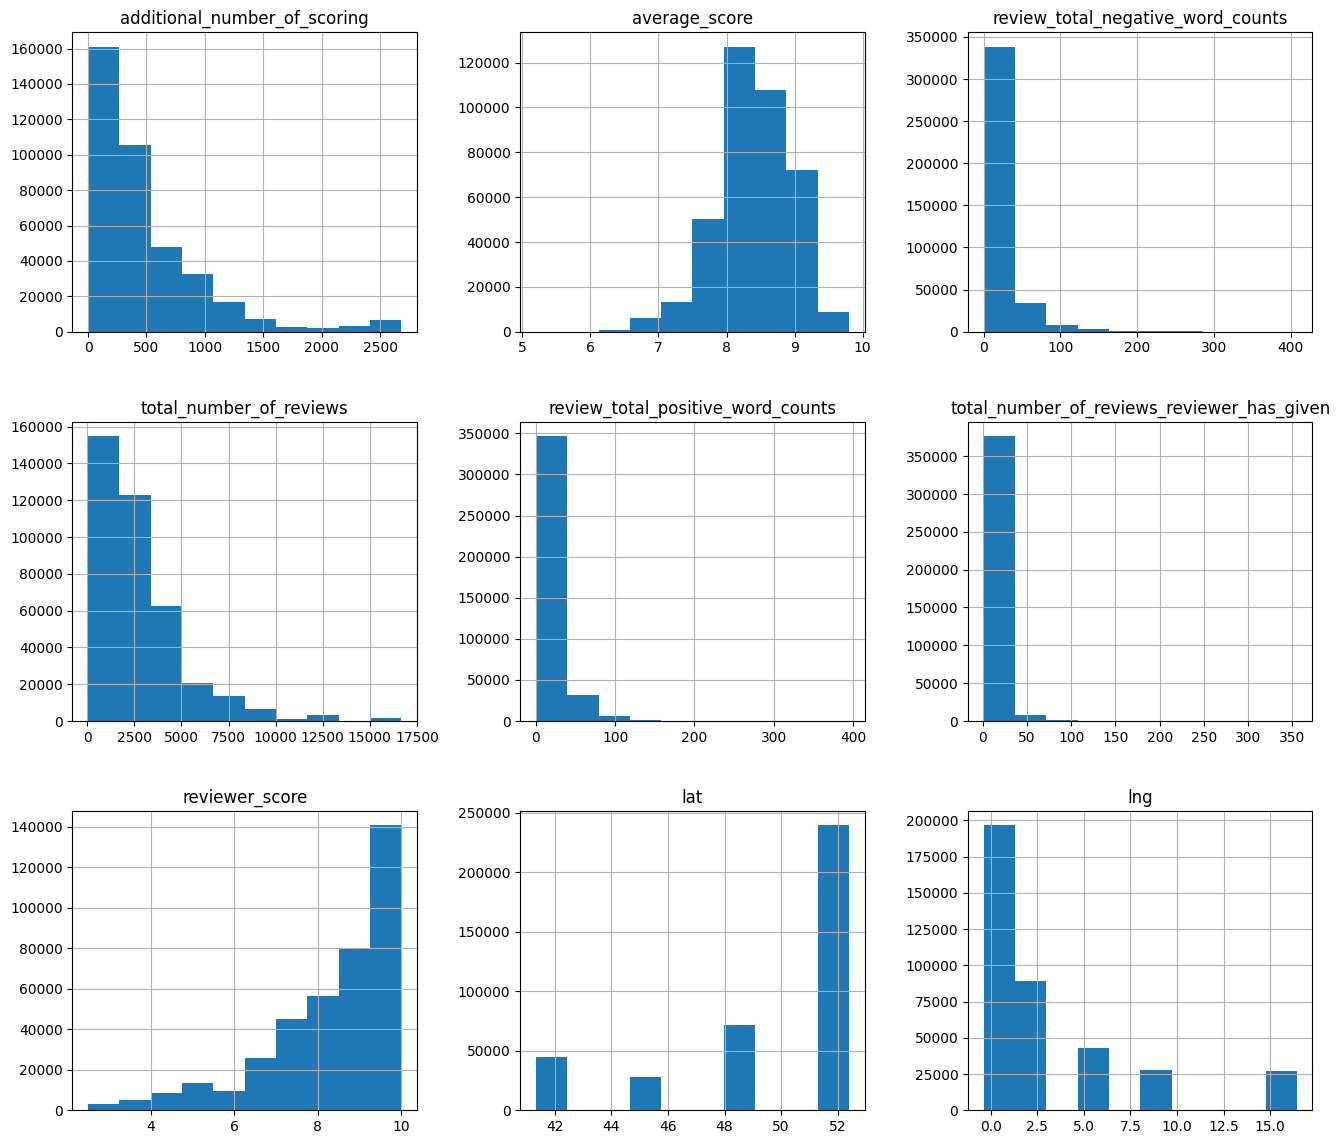

In [19]:
df_train.hist(figsize=(16,14));

Признаки 'lat', 'lng' и 'sample' нас пока не интересуют. 'reviewer_score' и 'average_score' явных выбросов не имеют (что логично для шкалированных оценок). Для остальных признаков построим коробчатые диаграммы, чтобы лучше увидеть потенциальные выбросы.

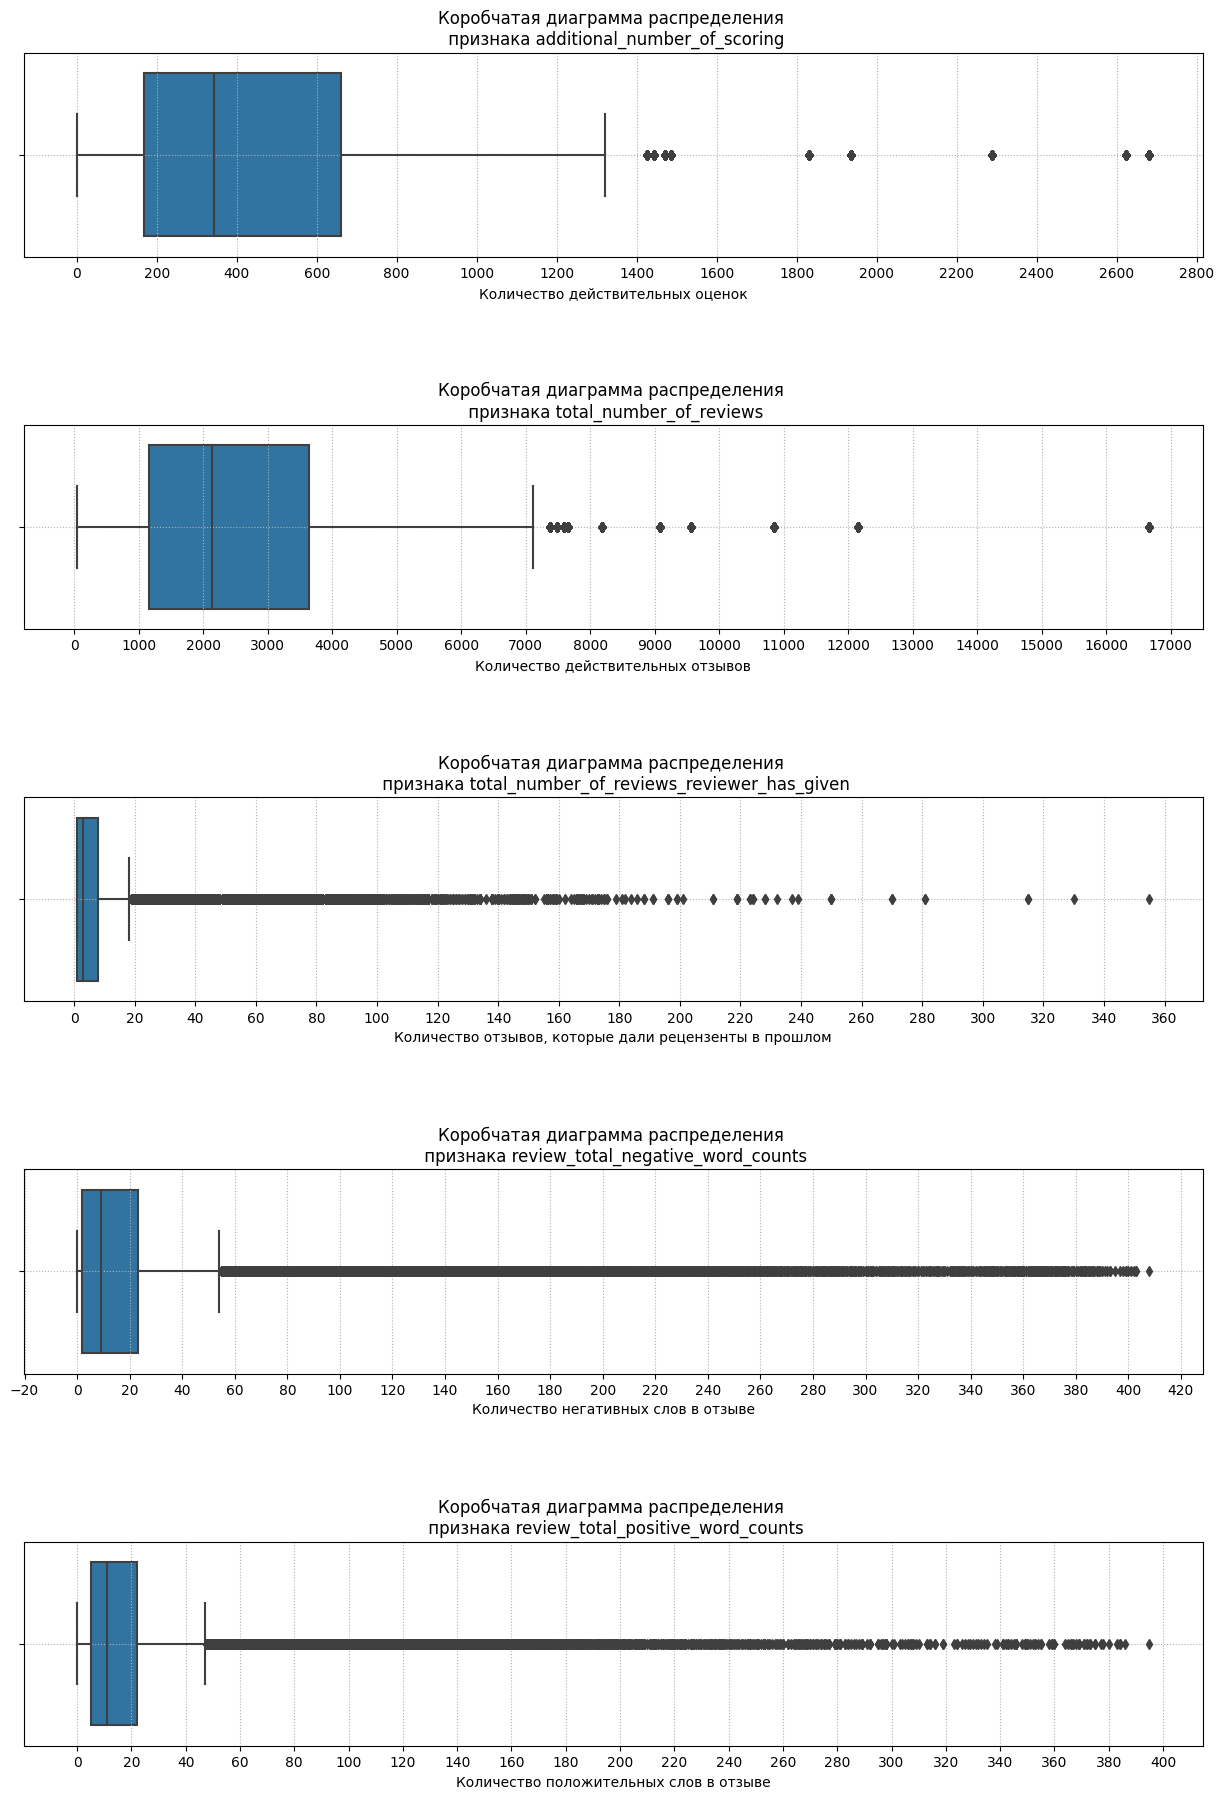

In [20]:
fig,axes = plt.subplots(nrows=5, ncols=1, figsize=(15, 20))
fig.tight_layout(pad=10.0)

boxplot1 = sns.boxplot(data=df_train, x='additional_number_of_scoring', ax=axes[0])
boxplot1.set_title('Коробчатая диаграмма распределения \n признака additional_number_of_scoring')
boxplot1.set_xlabel('Количество действительных оценок')
boxplot1.xaxis.set_major_locator(ticker.MultipleLocator(200)) # меняем шаг оси х
boxplot1.grid(linestyle=':')

boxplot2 = sns.boxplot(data=df_train, x='total_number_of_reviews', ax=axes[1])
boxplot2.set_title('Коробчатая диаграмма распределения \n признака total_number_of_reviews')
boxplot2.set_xlabel('Количество действительных отзывов')
boxplot2.xaxis.set_major_locator(ticker.MultipleLocator(1000)) # меняем шаг оси х
boxplot2.grid(linestyle=':')

boxplot3 = sns.boxplot(data=df_train, x='total_number_of_reviews_reviewer_has_given', ax=axes[2])
boxplot3.set_title('Коробчатая диаграмма распределения \n признака total_number_of_reviews_reviewer_has_given')
boxplot3.set_xlabel('Количество отзывов, которые дали рецензенты в прошлом')
boxplot3.xaxis.set_major_locator(ticker.MultipleLocator(20)) # меняем шаг оси х
boxplot3.grid(linestyle=':')

boxplot4 = sns.boxplot(data=df_train, x='review_total_negative_word_counts', ax=axes[3])
boxplot4.set_title('Коробчатая диаграмма распределения \n признака review_total_negative_word_counts')
boxplot4.set_xlabel('Количество негативных слов в отзыве')
boxplot4.xaxis.set_major_locator(ticker.MultipleLocator(20)) # меняем шаг оси х
boxplot4.grid(linestyle=':')

boxplot5 = sns.boxplot(data=df_train, x='review_total_positive_word_counts', ax=axes[4])
boxplot5.set_title('Коробчатая диаграмма распределения \n признака review_total_positive_word_counts')
boxplot5.set_xlabel('Количество положительных слов в отзыве')
boxplot5.xaxis.set_major_locator(ticker.MultipleLocator(20)) # меняем шаг оси х
boxplot5.grid(linestyle=':')

Коробчатые диаграммы подтвердили наличие выбросов во всех рассматриваемых признаках. В 'review_total_negative_words' и 'review_total_positive_words' удаление выбросов по коробчатой диаграмме и методом трех сигм ухудшало метрику. Для 'total_number_of_reviews_reviewer_has_given' позднее создадим признак-мигалку, так как удаление выбросов также приводит к ухудшению метрики. Для остальных удалим выбросы по коробчатым диаграммам.

In [21]:
mask_outliers = ((df_train['additional_number_of_scoring'] > 1400)|
                (df_train['total_number_of_reviews'] > 8000)
                )
df_train_anomalies = df_train[mask_outliers]
df_train = df_train.drop(df_train_anomalies.index)
print('Найдено выбросов:', df_train_anomalies.shape[0])

Найдено выбросов: 25774


Теперь объединим датасеты для синхронных преобразований.

In [22]:
df_train['sample'] = 1 # отмечаем данные для обучения
df_test['sample'] = 0 # отмечаем данные для тестирования
df_test['reviewer_score'] = 0 # заполняем тестовые предсказания на 0

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

C:\Users\incon\AppData\Local\Temp\ipykernel_20204\1781568430.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 489657 entries, 0 to 489656
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               489657 non-null  object 
 1   additional_number_of_scoring                489657 non-null  int64  
 2   review_date                                 489657 non-null  object 
 3   average_score                               489657 non-null  float64
 4   hotel_name                                  489657 non-null  object 
 5   reviewer_nationality                        489657 non-null  object 
 6   negative_review                             489657 non-null  object 
 7   review_total_negative_word_counts           489657 non-null  int64  
 8   total_number_of_reviews                     489657 non-null  int64  
 9   positive_review                             489657 non-null  object 
 

Признаки, которые мы имеем в датасете на данном этапе:

* hotel_address — адрес отеля
* review_date — дата, когда рецензент разместил соответствующий отзыв
* average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год
* hotel_name — название отеля
* reviewer_nationality — страна рецензента
* negative_review — отрицательный отзыв, который рецензент дал отелю
* review_total_negative_word_counts — общее количество слов в отрицательном отзыв
* positive_review — положительный отзыв, который рецензент дал отелю
* review_total_positive_word_counts — общее количество слов в положительном отзыве
* reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта
* total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом
* total_number_of_reviews — общее количество действительных отзывов об отеле
* tags — теги, которые рецензент дал отелю
* days_since_review — количество дней между датой проверки и датой очистки
* additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
* lat — географическая широта отеля
* lng — географическая долгота отеля

Как видно из информации о признаках, пустые значения есть только в признаках lat и lng. Остальные признаки пропусков не имеют.

Посчитаем количество числовых признаков, с которыми может работать модель.

In [24]:
data_columns = data.columns
numtype_columns = list()
numtype = ['int8', 'int16', 'int32', 'int64', 'uint8', 'uint16', 'uint32', 'uint64', 'float16', 'float32', 'float64']
for elem in data_columns:
    if data.dtypes[elem] in numtype:
        numtype_columns.append(elem)
        continue
    else:
        continue
    
display('Столбцы с числовым форматом данных:', numtype_columns)
print('Количество столбцов в числовом формате:', len(numtype_columns))

'Столбцы с числовым форматом данных:'

['additional_number_of_scoring',
 'average_score',
 'review_total_negative_word_counts',
 'total_number_of_reviews',
 'review_total_positive_word_counts',
 'total_number_of_reviews_reviewer_has_given',
 'lat',
 'lng',
 'sample',
 'reviewer_score']

Количество столбцов в числовом формате: 10


10 имеют числовой тип данных, причем два из них имеют пропуски, а два это признак-мигалка для разделения на тренировочные данные и тестовые и целевой признак, который нам нужно предсказать. Негусто... Поэтому необходимо преобразовать или выделить из нечисловых данных числовые, с которыми сможет работать модель машинного обучения.

## Преобразование признаков

### Преобразуем адрес

Из признака hotel_address выделим страну отеля, город отеля и почтовый индекс. Посмотрим много ли стран и городов и можно ли почтовый индекс использовать как числовой, для определения категории района города, ведь в городах есть престижные районы с хорошими отелями и окружающей инфраструктурой и районы неблагополучные, в которых даже хороший отель может оставить неприятные впечатления.

Так как адреса отелей имеют одинаковую структуру, то с помощью .split() выделим нужные нам значения.

In [25]:
#функция получения страны отеля из адреса, на вход поступает адресс отеля, а возвращается страна
def hotel_country(address):
    address = address.split(' ')[::-1] #делим строку и зеркалим для удобства
    country = str()
    # В данных есть страна United Kingdom (из двух слов), остальные состоят из 1 слова,
    # поэтому для Великобритании отдельное условие
    if 'Kingdom' in address:
        country = address[0:2]
        country = ' '.join(country[::-1])
    else:
        country = str(address[0])
    return country


In [26]:
# функция получения города отеля из адреса, на вход поступает адресс отеля, а возвращается город
def hotel_city(address):
    address = address.split(' ')[::-1] #делим строку и зеркалим для удобства
    city_name = str()
    # В данных есть страна United Kingdom (из двух слов), остальные состоят из 1 слова,
    # поэтому для Великобритании отдельное условие
    if 'Kingdom' in address:
        city = address[4:5]
        city = ' '.join(city[::-1])
    else:
        city = str(address[1])
    return city

In [27]:
# функция получения почтового кода отеля из адреса, на вход поступает адресс отеля, а возвращается почтовый индекс
def hotel_postal_code(address):
    address = address.split(' ')[::-1]
    postal_code = str()
    # В Великобритании и Нидерландах двойные индексы
    if 'Kingdom' in address or 'Amsterdam'in address:
        postal_code = address[2:4]
        postal_code = ' '.join(postal_code[::-1])
    else:
        postal_code = str(address[2])
    return postal_code

In [28]:
data['hotel_country'] = data['hotel_address'].apply(hotel_country)
print('Количество стран, из которых отели в датасете:', data['hotel_country'].value_counts().count())


Количество стран, из которых отели в датасете: 6


In [29]:
data['hotel_city'] = data['hotel_address'].apply(hotel_city)
print('Количество городов, из которых отели в датасете:', data['hotel_city'].value_counts().count())


Количество городов, из которых отели в датасете: 6


Городов оказалось 6 из 6 стран, то есть каждый город из отдельной страны. В дальнейшем попробую использовать скорее всего город для кодировки, страну использовать не буду, так как город и так однозначно укажет на страну.

In [30]:
data['hotel_postal_code'] = data['hotel_address'].apply(hotel_postal_code)
print('Количество уникальных почтовых индексов отелей в датасете:', data['hotel_postal_code'].value_counts().count())
display(data['hotel_postal_code'].value_counts())

Количество уникальных почтовых индексов отелей в датасете: 602


1010       12439
20124      11726
75008      11119
08002      10174
75001       5539
           ...  
20141         22
1230          21
1017 JW       17
E2 7DD        12
92120         10
Name: hotel_postal_code, Length: 602, dtype: int64

К сожалению почтовые индексы для некоторых стран не числовые, а уникальных значений более 600, попробовала закодировать двоичным кодированием, но это привело к ухудшению метрики. Поэтому признак почтового индекса использовать не буду, лучше попробовать заполнить пропуски в координатах и вычислить расстояние от центра города до отеля.

А пока проверим количество уникальных названий отелей и уникальных адресов.

In [31]:
print('Количество уникальных названий отелей', data['hotel_name'].value_counts().count())
print('Количество уникальных названий адресов', data['hotel_address'].value_counts().count())

Количество уникальных названий отелей 1492
Количество уникальных названий адресов 1493


Так как количество не совпадает, предполагаем, что некоторые отели имеют одинаковое название, но расположены в разных местах, поэтому создадим временный признак, в котором объединим название и адрес отеля для лучшей идентификации.

In [32]:
data['hotel'] = data['hotel_name']+ data['hotel_address']
data['hotel'].value_counts().count()

1494

#### Преобразуем широту и долготу

Так как пока не удалось преобразовать признак почтового кода в числовой, то заполним недостающие значения долготы и широты и по координатам определим удаленность отеля от центра города, в котором он находится.

In [33]:
mask = (data['lat'].isnull() == True)|(data['lng'].isnull() == True)
print('Количество отелей с отсутствием координат:', data[mask]['hotel'].value_counts().count())

Количество отелей с отсутствием координат: 17


Так как всего у 17 отелей пропущены широта и долгота, то не имеет смысла подгружать данные из внешних источников, проще и быстрее будет заполнить вручную. Создадим словарь, где ключом является название+адрес отеля, а значением список из широты и долготы.

In [34]:
# Для читаемости кода создадим список названий+адресов отелей, в которых есть пропуски координат
lat_lng_less = data[mask]['hotel'].value_counts()
lat_lng_less

Fleming s Selection Hotel Wien CityJosefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria      658
Hotel City CentralTaborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria                               563
Hotel AtlantaW hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria                               389
Maison Albar Hotel Paris Op ra Diamond4 rue de la P pini re 8th arr 75008 Paris France              290
Hotel Daniel ViennaLandstra er G rtel 5 03 Landstra e 1030 Vienna Austria                           245
Hotel Pension Baron am SchottentorW hringer Stra e 12 09 Alsergrund 1090 Vienna Austria             223
Austria Trend Hotel Schloss Wilhelminenberg WienSavoyenstra e 2 16 Ottakring 1160 Vienna Austria    194
Derag Livinghotel Kaiser Franz Joseph ViennaSieveringer Stra e 4 19 D bling 1190 Vienna Austria     147
NH Collection Barcelona PodiumBail n 4 6 Eixample 08010 Barcelona Spain                             146
City Hotel DeutschmeisterGr nentorgasse 30 09 Alsergrund 1090 Vi

In [35]:
# Словарь, где ключ - название+адрес отеля, значение - список[широта, долгота]
hotels_nowhere = {
    lat_lng_less.index[0]:[48.2094018,16.3534456],
    lat_lng_less.index[1]:[48.213587,16.3773333],
    lat_lng_less.index[2]:[48.2204104,16.3532437],
    lat_lng_less.index[3]:[48.8753173,2.3208171],
    lat_lng_less.index[4]:[48.1888148,16.3812044],
    lat_lng_less.index[5]:[48.2167996,16.3573308],
    lat_lng_less.index[6]:[48.2195694,16.2830172],
    lat_lng_less.index[7]:[48.2458873,16.339354],
    lat_lng_less.index[8]:[41.391548,2.1753191],
    lat_lng_less.index[9]:[48.2208519,16.3640366],
    lat_lng_less.index[10]:[48.2205671,16.2152523],
    lat_lng_less.index[11]:[48.2095489,16.3488884],
    lat_lng_less.index[12]:[48.8889092,2.3305781],
    lat_lng_less.index[13]:[48.2227607,16.3909124],
    lat_lng_less.index[14]:[48.8377262,2.3159061],
    lat_lng_less.index[15]:[41.3926849,2.1648227],
    lat_lng_less.index[16]:[41.3832385,2.1603747]
    }

In [36]:
# заполняем пустые значения координат отелей на 0, для удобства отсеивания по условию
data['lat'] = data['lat'].fillna(0)
data['lng'] = data['lng'].fillna(0)

In [37]:
# Функция для заполнения широты, принимает название_адрес отеля и широту, возвращает обновленную широту
def full_lat(hotel, lat):
    if lat == 0:
        if hotel in hotels_nowhere:
            lat = hotels_nowhere[hotel][0]
    return lat

data['lat'] = data.apply(lambda x: full_lat(x['hotel'], x['lat']), axis=1)

# Функция для заполнения долготы, принимает название_адрес отеля и долготу, возвращает обновленную долготу
def full_lat(hotel, lng):
    if lng == 0:
        if hotel in hotels_nowhere:
            lng = hotels_nowhere[hotel][1]
    return lng

data['lng'] = data.apply(lambda x: full_lat(x['hotel'], x['lng']), axis=1)

# Убедимся, что функции сработали корректно
data.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,tags,days_since_review,lat,lng,sample,reviewer_score,hotel_country,hotel_city,hotel_postal_code,hotel
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,...,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0,Italy,Milan,20161,Hotel Da VinciVia Senigallia 6 20161 Milan Italy
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,...,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0,Netherlands,Amsterdam,1043 EW,Urban Lodge HotelArlandaweg 10 Westpoort 1043 ...


In [38]:
# Словарь, в котором ключи - названия городов, значения - список[широта центра города, долгота центра города]
centers_cities = {
    'London':[51.5085300, -0.1257400],
    'Barcelona':[41.3887900, 2.1589900],
    'Paris':[48.8534100, 2.3488000],
    'Amsterdam':[52.3740300, 4.8896900],
    'Vienna':[48.2084900, 16.3720800],
    'Milan':[45.4642700, 9.1895100]
}

По координатам вычислим расстояние от отеля до центра города, в километры переводить не буду, так как все расстояния и так в одних и тех же измерениях, пока оставлю как есть. Выход к морю есть только в 2-х городах из 6-ти, поэтому создавать признак расстояния до моря пока не буду. В будущем можно попробовать создать признаки расстояния до моря, или наличие моря, а также перевести расстояния в киллометры.

In [39]:
# Заполняем временные признаки широты и долготы центра города по словарю
data['center_lat'] = data['hotel_city'].apply(lambda x: centers_cities[x][0])
data['center_lng'] = data['hotel_city'].apply(lambda x: centers_cities[x][1])
# Вычисляем расстояние от отеля до центра
data['distance_to_center'] = (data['center_lat']-data['lat'])**2 + (data['center_lng']-data['lng'])**2
data['distance_to_center'] = data['distance_to_center'].apply(lambda x: round(math.sqrt(x),5))
data.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,lng,sample,reviewer_score,hotel_country,hotel_city,hotel_postal_code,hotel,center_lat,center_lng,distance_to_center
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,...,9.171102,0,0.0,Italy,Milan,20161,Hotel Da VinciVia Senigallia 6 20161 Milan Italy,45.46427,9.18951,0.07128
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,...,4.834443,0,0.0,Netherlands,Amsterdam,1043 EW,Urban Lodge HotelArlandaweg 10 Westpoort 1043 ...,52.37403,4.88969,0.05646


#### Закодируем названия городов

Так как в нашем датасете всего 6 уникальных городов из 6 стран, закодируем названия городов, в которых расположены отели с помощью OneHotEncoder. Используем названия городов, а не стран, так как, в отличие от названий стран, все названия городов состоят из одного слова, это удобно при наименовании признаков. Названия стран кодировать не будем, так как это не имеет смысла, ведь в нашем датасете из каждой страны представлен только один город.

In [40]:
encoder = ce.OneHotEncoder(cols=['hotel_city'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(data['hotel_city'])
data = pd.concat([data, type_bin], axis=1)

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 489657 entries, 0 to 489656
Data columns (total 31 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               489657 non-null  object 
 1   additional_number_of_scoring                489657 non-null  int64  
 2   review_date                                 489657 non-null  object 
 3   average_score                               489657 non-null  float64
 4   hotel_name                                  489657 non-null  object 
 5   reviewer_nationality                        489657 non-null  object 
 6   negative_review                             489657 non-null  object 
 7   review_total_negative_word_counts           489657 non-null  int64  
 8   total_number_of_reviews                     489657 non-null  int64  
 9   positive_review                             489657 non-null  object 
 

#### Преобразуем признаки days_since_review

Преобразуем признак days_since_review в числовой формат.

In [42]:
data['days_since_review'] = data['days_since_review'].apply(lambda x: x.replace(' days', ''))
data['days_since_review'] = data['days_since_review'].apply(lambda x: int(x.replace(' day', '')))
data['days_since_review'].head()

0     13
1    234
2    616
3    656
4    444
Name: days_since_review, dtype: int64

#### Преобразуем признак страны рецензента

Для начала проверим нет ли в нашем датасете рецензентов, которые останавливались в отелях в своей же стране, то есть локальных путешественников.

In [43]:
data['reviewer_nationality'].value_counts()


 United Kingdom               228404
 United States of America      34569
 Australia                     21013
 Ireland                       13969
 United Arab Emirates           9887
                               ...  
 Cape Verde                        1
 Wallis and Futuna                 1
 Svalbard Jan Mayen                1
 Northern Mariana Islands          1
 Vatican City                      1
Name: reviewer_nationality, Length: 226, dtype: int64

Как видно из уникальных значений, все национальности начинаются с пробела, уберем пробелы в странах рецензента и странах отеля и создадим признак локальности туриста, где 0 - международный турист, а 1 - локальный турист.

In [44]:
data['reviewer_nationality_temp'] = data['reviewer_nationality'].apply(lambda x: x.replace(' ',''))
data['hotel_country_temp'] = data['hotel_country'].apply(lambda x: x.replace(' ',''))
cols = ['reviewer_nationality_temp','hotel_country_temp']
data['local_tourist'] = data[cols].apply(lambda x: 1 if x[cols[0]]==x[cols[1]] else 0, axis=1)
cols = ['hotel_country_temp', 'reviewer_nationality_temp']
data.drop(cols, axis = 1, inplace=True)
data['local_tourist'].value_counts()

0    327258
1    162399
Name: local_tourist, dtype: int64

Посмотрим оставляют ли локальные туристы более позитивные отзывы.

In [45]:
local_international = data.groupby(['local_tourist']).agg({
    'review_total_negative_word_counts':'median',
    'review_total_positive_word_counts':'median',
    'average_score':'median',
    'reviewer_score':'median'
    }).rename(columns={
        'review_total_negative_word_counts':'median_neg_word',
        'review_total_positive_word_counts':'median_pos_word',
        'average_score':'median_average_score', 
        'reviewer_score':'median_reviewer_score'})
display(local_international)

,median_neg_word,median_pos_word,median_average_score,median_reviewer_score
local_tourist,,,,
0,9.0,11.0,8.5,7.9
1,9.0,11.0,8.4,7.9


Как видим и локальные и международные туристы ставят примерно одинаковые оценки, но локальные туристы чаще выбирают отели с рейтингом в среднем ниже, возможно это связано с ценой.

Объединим страны, из которых было менее 1% рецензентов под общим 'another countries'. Закодируем признак страны, так как разные национальности могут быть более лояльны к неудобствам, если это принято в их культуре.

In [46]:
reviewer_nationality = data['reviewer_nationality'].value_counts(normalize=True).nlargest(15)
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x if x in reviewer_nationality else 'another countries')

bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality'])
nationality_bin = bin_encoder.fit_transform(data['reviewer_nationality'])
data = pd.concat([data, nationality_bin], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 489657 entries, 0 to 489656
Data columns (total 37 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               489657 non-null  object 
 1   additional_number_of_scoring                489657 non-null  int64  
 2   review_date                                 489657 non-null  object 
 3   average_score                               489657 non-null  float64
 4   hotel_name                                  489657 non-null  object 
 5   reviewer_nationality                        489657 non-null  object 
 6   negative_review                             489657 non-null  object 
 7   review_total_negative_word_counts           489657 non-null  int64  
 8   total_number_of_reviews                     489657 non-null  int64  
 9   positive_review                             489657 non-null  object 
 

#### Преобразуем признак tags

Создадим признак количества ночей из признака tags, на которые останавливались туристы. Если тега с указанием количества ночей нет, то присвоим число -99.

In [47]:
data['tags'].value_counts()

[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']                             4956
[' Leisure trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']                    4333
[' Leisure trip ', ' Couple ', ' Superior Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']                    4171
[' Leisure trip ', ' Couple ', ' Deluxe Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']                      3987
[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']                            3157
                                                                                                                                    ... 
[' Leisure trip ', ' Family with older children ', ' Quadruple Suite ', ' Stayed 3 nights ', ' Submitted from a mobile device ']       1
[' Leisure trip ', ' Family with young ch

In [48]:
reg = r'(Stayed).\w{1,35}'           
data['stayed_nights'] = data['tags'].apply(
    lambda x: re.search(reg, x, flags=0).group(0) if re.search(reg, x, flags=0) is not None else -99
    )
data['stayed_nights'] = data['stayed_nights'].apply(lambda x: int(x.split(' ')[-1]) if x != -99 else -99)
data['stayed_nights'].value_counts()

 1     180873
 2     127110
 3      92292
 4      46365
 5      20194
 6       9448
 7       7156
 8       2404
 9       1245
 10       850
 11       398
 12       297
 13       234
 14       233
-99       182
 15       113
 16        53
 17        41
 18        33
 19        26
 21        23
 20        17
 27        11
 30        11
 23         9
 25         7
 26         7
 22         7
 24         6
 28         6
 29         5
 31         1
Name: stayed_nights, dtype: int64

Как видим большинство туристов проживали в отеле менее недели. Самым популярным сроком является 1 ночь. Также можно увидеть, что 192 рецензента не указали срок своего пребывания в тегах. В дальнейшем можно заполнить эти 192 значения на медиану или среднее, пока оставим так.

Так же из признака tags выделим признак типа отдыха туриста, если тип отдыха не указан, поставим значение 'Unknown'. Возможно туристы в деловых поездках оставляют больше положительных отзывов, так как зачастую меньшее время находятся в отеле. Или наоборот они более требовательны.

In [49]:
reg = r'(Leisure trip)|(Business trip)'           
data['trips_purpose'] = data['tags'].apply(
    lambda x: re.search(reg, x, flags=0).group(0) if re.search(reg, x, flags=0) is not None else 'Unknown'
    )
data['trips_purpose'] = data['trips_purpose'].replace({'Leisure trip':'leisure', 'Business trip':'business','Unknown':'unknown'})
data['trips_purpose'].value_counts()

leisure     396619
business     78853
unknown      14185
Name: trips_purpose, dtype: int64

Посмотрим сколько положительных и отрицательных отзывов оставили туристы в зависимости от типа отдыха.

In [50]:
kind_of_trip = data.groupby(['trips_purpose']).agg({
    'review_total_negative_word_counts':'median',
    'review_total_positive_word_counts':'median',
    'average_score':'median',
    'reviewer_score':'median',
    'trips_purpose':'count',
    'local_tourist': 'sum'
    }).rename(columns={
        'review_total_negative_word_counts':'median_neg_word',
        'review_total_positive_word_counts':'median_pos_word',
        'average_score':'median_average_score', 
        'reviewer_score':'median_reviewer_score',
        'trips_purpose':'total_tourists',
        'local_tourist': 'local_tourists'
        })
display(kind_of_trip)

,median_neg_word,median_pos_word,median_average_score,median_reviewer_score,total_tourists,local_tourists
trips_purpose,,,,,,
business,10.0,9.0,8.4,7.5,78853,25206
leisure,9.0,12.0,8.5,8.3,396619,131494
unknown,9.0,9.0,8.3,7.5,14185,5699


Можно сделать вывод, что отдыхающие рецензенты оставляют отзывы и оценки позитивнее, чем путешествующие по рабочим вопросам. Поэтому закодируем признак цели путешествия с помощью однократного кодирования.

In [51]:
encoder = ce.OneHotEncoder(cols=['trips_purpose'], use_cat_names=True)
type_bin = encoder.fit_transform(data['trips_purpose'])
data = pd.concat([data, type_bin], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 489657 entries, 0 to 489656
Data columns (total 42 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               489657 non-null  object 
 1   additional_number_of_scoring                489657 non-null  int64  
 2   review_date                                 489657 non-null  object 
 3   average_score                               489657 non-null  float64
 4   hotel_name                                  489657 non-null  object 
 5   reviewer_nationality                        489657 non-null  object 
 6   negative_review                             489657 non-null  object 
 7   review_total_negative_word_counts           489657 non-null  int64  
 8   total_number_of_reviews                     489657 non-null  int64  
 9   positive_review                             489657 non-null  object 
 

Посмотрим какие еще теги указаны в отзывах.

In [52]:
data['tags'].value_counts()

[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']                             4956
[' Leisure trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']                    4333
[' Leisure trip ', ' Couple ', ' Superior Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']                    4171
[' Leisure trip ', ' Couple ', ' Deluxe Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']                      3987
[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']                            3157
                                                                                                                                    ... 
[' Leisure trip ', ' Family with older children ', ' Quadruple Suite ', ' Stayed 3 nights ', ' Submitted from a mobile device ']       1
[' Leisure trip ', ' Family with young ch

Создадим признак типа туристов.

In [53]:
reg = r'(Family with ).....( children)|(Solo traveler)|(Couple)|(Group)|(Travelers with friends)'           
data['kind_of_tourist'] = data['tags'].apply(
    lambda x: re.search(reg, x, flags=0).group(0) if re.search(reg, x, flags=0) is not None else 'Unknown'
    )
data['kind_of_tourist'].value_counts()

Couple                        239470
Solo traveler                 103390
Group                          62024
Family with young children     57696
Family with older children     25017
Travelers with friends          2060
Name: kind_of_tourist, dtype: int64

Не будем кодировать, но переведем в числовой вид по примерной численности групп, где 1 - одинокие туристы, 2 - пара, 3 - семьи с детьми, а 4 - группы и друзья.

In [54]:
kind_of_tourist_dict = {
   'Solo traveler': 1,
    'Couple': 2,
    'Group': 4,
    'Family with young children': 3,
    'Family with older children': 3,
    'Travelers with friends': 4
}
data['kind_of_tourist'] = data['kind_of_tourist'].replace(kind_of_tourist_dict)
data['kind_of_tourist'].value_counts()

2    239470
1    103390
3     82713
4     64084
Name: kind_of_tourist, dtype: int64

#### Преобразуем признаки позитивных отзывов и негативных

Посмотрим на отзывы

In [55]:
data['positive_review'].value_counts().nlargest(30)

No Positive            33624
 Location               8610
 Everything             2148
 location               1564
 Nothing                1152
 The location           1082
 Great location          979
 Location                862
 Good location           862
 Everything              586
 Breakfast               572
 Friendly staff          490
 Staff                   437
 Excellent location      369
 Great location          354
 Location and staff      322
 everything              309
 Good location           254
 Nothing                 204
 Comfy bed               203
 nothing                 199
 The location            199
 good location           196
 The staff               191
 Good breakfast          177
 the location            176
 Location staff          176
                         174
 Location was good       170
 Every thing             166
Name: positive_review, dtype: int64

In [56]:
data['negative_review'].value_counts().nlargest(30)

No Negative            122682
 Nothing                13691
 Nothing                 4064
 nothing                 2147
 N A                      981
 None                     942
                          826
 N a                      487
 Breakfast                382
 Small room               365
 Location                 348
 Nothing really           304
 All good                 303
 none                     293
 Everything               293
 nothing                  276
 No complaints            265
 Price                    253
 Nil                      240
 Nothing really           234
 Nothing at all           214
 n a                      213
 Nothing to dislike       194
 Small rooms              188
 Nothing at all           185
 None                     177
 No complaints            170
 All good                 148
 Room size                138
 NA                       137
Name: negative_review, dtype: int64

Для удобства приведем все слова к нижнему регистру и уберем первый и последний пробелы в обоих признаках.

In [57]:
data['positive_review'] = data['positive_review'].apply(lambda x: x.strip().lower())
data['positive_review'].value_counts().nlargest(15)

no positive                   33624
location                      11158
everything                     3138
nothing                        1599
great location                 1585
the location                   1535
good location                  1396
breakfast                       753
friendly staff                  700
excellent location              603
staff                           535
location and staff              438
location staff                  420
location location location      326
location was great              306
Name: positive_review, dtype: int64

In [58]:
data['negative_review'] = data['negative_review'].apply(lambda x: x.strip().lower())
data['negative_review'].value_counts().nlargest(15)

no negative           122682
nothing                20319
n a                     1720
none                    1445
                         826
nothing really           618
small room               557
all good                 522
breakfast                516
no complaints            507
location                 470
nothing at all           448
everything               379
nothing to dislike       348
price                    331
Name: negative_review, dtype: int64

Можно заметить положительные отзывы, в которых указано совсем не положительное, например "No positive" или "nothing", а также есть 183 отзыва без каких_либо слов, скорее всего там пробел. Создадим признак-противоречие, где поставим таким отзывам значение 0 - если в отзыве противоречие и 1, если противоречий нет. Сразу проверим позитивные и негативные отзывы. И также отметим противоречивыми отзывы без слов или со словом наподобие "N A"

In [59]:
def discrepancy(count_neg,count_pos,pos,neg):
    pos_lie_list = ['no positive', 'nothing',' ']
    neg_lie_list = ['no negative', 'nothing', 'n a', 'none', '', 'nothing really', 'all good', 'no complaints', 'nothing at all',
                    'nothing to dislike', 'nil', 'everithing was perfect', 'na', 'can t think of anything', 'leaving',
                    'absolutly nothing', 'everything was great', 'nothing to complain about', 'no', 'having to leave',
                    'everything was good', 'i liked everything', 'liked everything', 'nothing it was perfect',
                    'nothing everything was perfect', 'nothing everything was great', 'everything was fine', 'all was good',
                    'nothing comes to mind', 'non'
                   ]
    if count_pos > 0 and pos.lower() in pos_lie_list:
            result = 0
    elif count_neg > 0 and neg.lower() in neg_lie_list:
            result = 0
    else:
        result = 1
    return result
cols = ['review_total_negative_word_counts','review_total_positive_word_counts', 'positive_review', 'negative_review']
data['discrepancy'] = data.apply(lambda x: discrepancy(x[cols[0]], x[cols[1]], x[cols[2]], x[cols[3]]), axis=1)
data['discrepancy'].value_counts()

1    458256
0     31401
Name: discrepancy, dtype: int64

Попробуем вывести часто встречающиеся жалобы и похвалы и создать несколько признаков-мигалок. Например, в позитивных отзывах часто хвалят персонал, расположение отеля, завтраки и тому подобное. Во всех признаках-мигалках цифрой 1 обозначим наличие слова в отзыве, а 0 - отсутствие.

In [60]:
reg = r'(location)|(position)'           
data['positive_location'] = data['positive_review'].apply(lambda x: 1 if re.search(reg, x, flags=0) is not None else 0)
data['positive_location'].value_counts()

0    305532
1    184125
Name: positive_location, dtype: int64

In [61]:
reg = r'(location)|(position)'           
data['negative_location'] = data['negative_review'].apply(lambda x: 1 if re.search(reg, x, flags=0) is not None else 0)
data['negative_location'].value_counts()

0    478654
1     11003
Name: negative_location, dtype: int64

In [62]:
reg = r'(staff)|(Staff)'           
data['positive_staff'] = data['positive_review'].apply(lambda x: 1 if re.search(reg, x, flags=0) is not None else 0)
data['positive_staff'].value_counts()

0    307189
1    182468
Name: positive_staff, dtype: int64

In [63]:
reg = r'(staff)'           
data['negative_staff'] = data['negative_review'].apply(lambda x: 1 if re.search(reg, x, flags=0) is not None else 0)
data['negative_staff'].value_counts()

0    457101
1     32556
Name: negative_staff, dtype: int64

In [64]:
reg = r'(staff)'           
data['positive_staff'] = data['positive_review'].apply(lambda x: 1 if re.search(reg, x, flags=0) is not None else 0)
data['positive_staff'].value_counts()

0    307189
1    182468
Name: positive_staff, dtype: int64

In [65]:
reg = r'(breakfast)'           
data['negative_breakfast'] = data['negative_review'].apply(lambda x: 1 if re.search(reg, x, flags=0) is not None else 0)
data['negative_breakfast'].value_counts()

0    442456
1     47201
Name: negative_breakfast, dtype: int64

In [66]:
reg = r'(breakfast)'           
data['positive_breakfast'] = data['positive_review'].apply(lambda x: 1 if re.search(reg, x, flags=0) is not None else 0)
data['positive_breakfast'].value_counts()

0    410849
1     78808
Name: positive_breakfast, dtype: int64

In [67]:
reg = r'(everithing)|(every thing)|(all)'           
data['negative_everithing'] = data['negative_review'].apply(lambda x: 1 if re.search(reg, x, flags=0) is not None else 0)
data['negative_everithing'].value_counts()

0    388417
1    101240
Name: negative_everithing, dtype: int64

In [68]:
reg = r'((everithing)|(every thing)|(all))'           
data['positive_everithing'] = data['positive_review'].apply(lambda x: 1 if re.search(reg, x, flags=0) is not None else 0)
data['positive_everithing'].value_counts()

0    408906
1     80751
Name: positive_everithing, dtype: int64

In [69]:
reg = r'(room)|(rooms)'           
data['negative_room'] = data['negative_review'].apply(lambda x: 1 if re.search(reg, x, flags=0) is not None else 0)
data['negative_room'].value_counts()

0    339713
1    149944
Name: negative_room, dtype: int64

In [70]:
reg = r'((room)|(rooms))'           
data['positive_room'] = data['positive_review'].apply(lambda x: 1 if re.search(reg, x, flags=0) is not None else 0)
data['positive_room'].value_counts()

0    334933
1    154724
Name: positive_room, dtype: int64

In [71]:
reg = r'(price)|(expensive)'           
data['negative_price'] = data['negative_review'].apply(lambda x: 1 if re.search(reg, x, flags=0) is not None else 0)
data['negative_price'].value_counts()

0    455456
1     34201
Name: negative_price, dtype: int64

In [72]:
reg = r'(price)|(expensive)'           
data['positive_price'] = data['positive_review'].apply(lambda x: 1 if re.search(reg, x, flags=0) is not None else 0)
data['positive_price'].value_counts()

0    477222
1     12435
Name: positive_price, dtype: int64

In [73]:
reg = r'(bed)|(pillows)'           
data['negative_bed'] = data['negative_review'].apply(lambda x: 1 if re.search(reg, x, flags=0) is not None else 0)
data['negative_bed'].value_counts()

0    451555
1     38102
Name: negative_bed, dtype: int64

In [74]:
reg = r'(bed)|(pillows)'           
data['positive_bed'] = data['positive_review'].apply(lambda x: 1 if re.search(reg, x, flags=0) is not None else 0)
data['positive_bed'].value_counts()

0    424719
1     64938
Name: positive_bed, dtype: int64

Признаки-мигалки очень хорошо повлияли на метрику. Так что их однозначно буду использовать при обучении модели.

#### Преобразуем признак 'total_number_of_reviews_reviewer_has_given'

Как проверено ранее, данный признак имеет выбросы, посмотрим на его распеределение более внимательно.

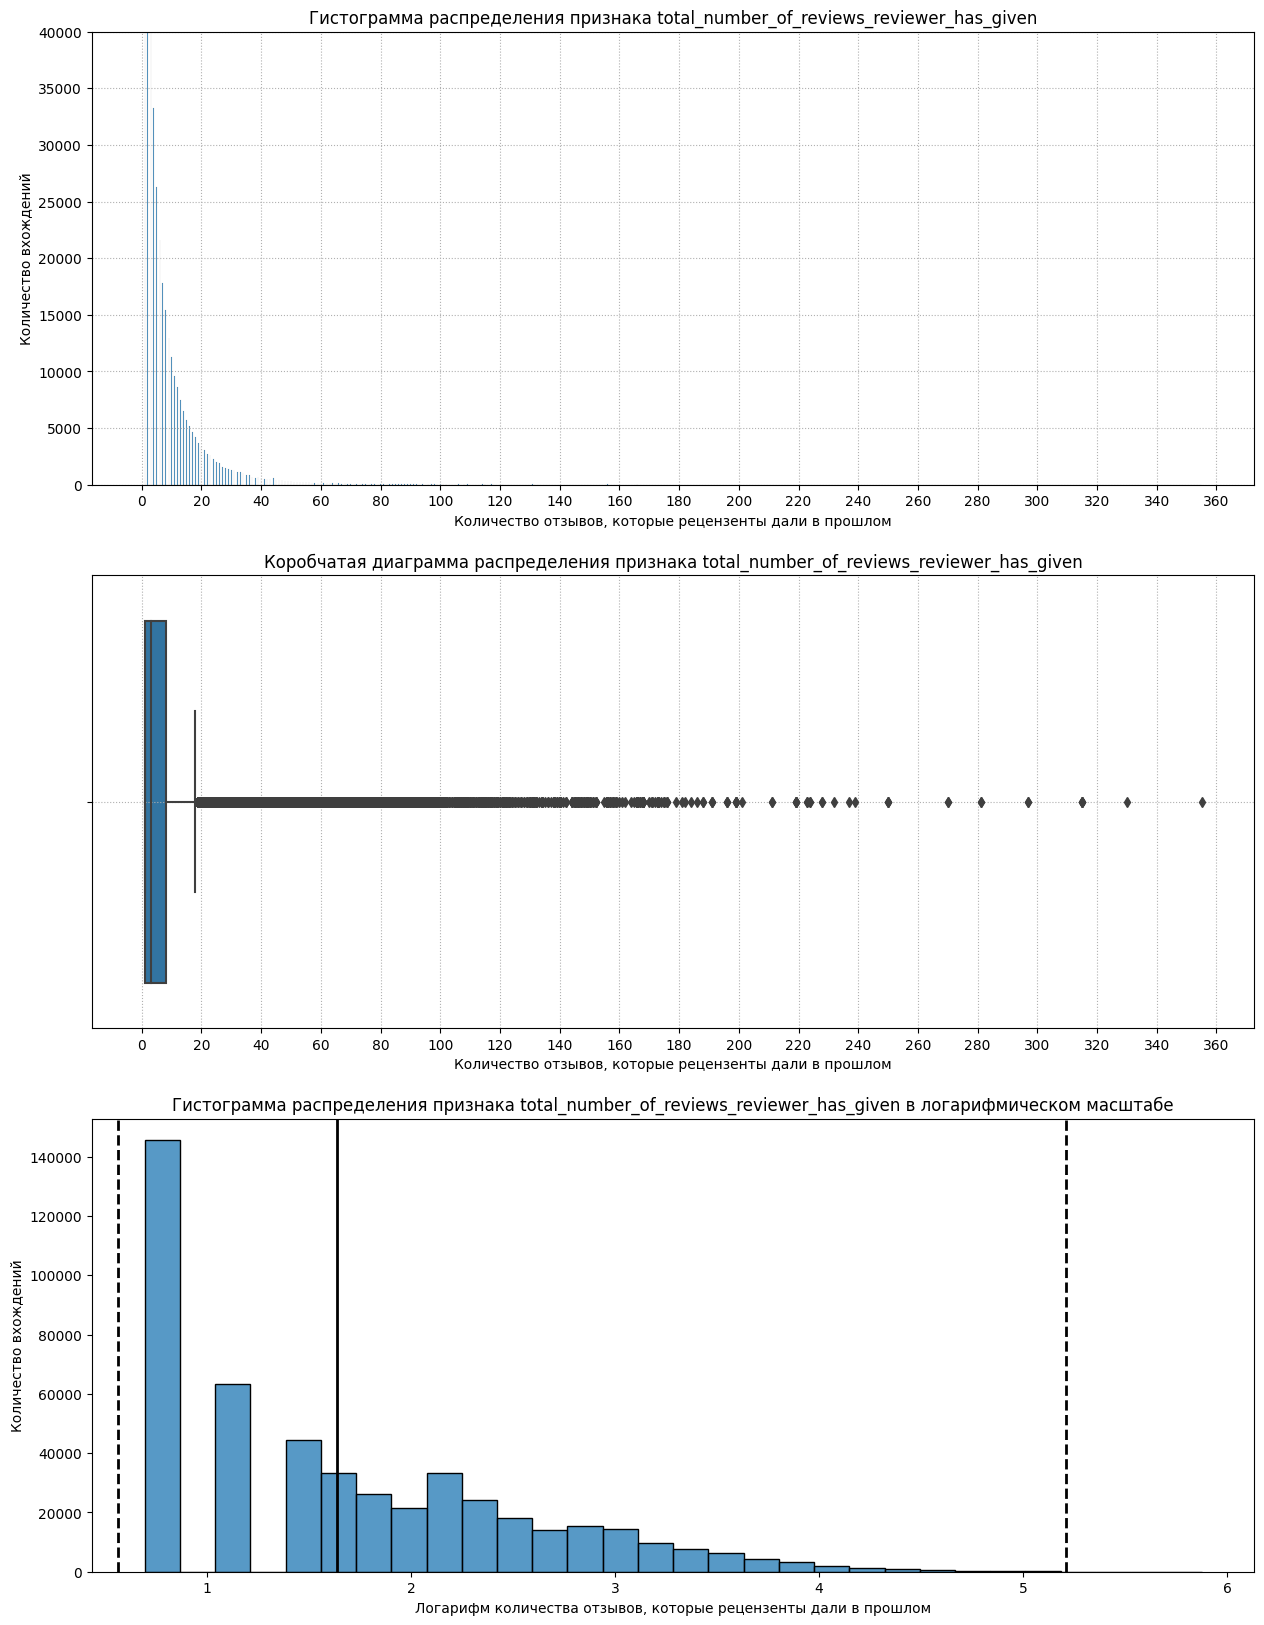

In [75]:
fig,axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 20))

# настраиваем гистограмму
histplot = sns.histplot(data=data, x='total_number_of_reviews_reviewer_has_given', ax=axes[0])
histplot.set_ylim(ymax = 40000)
histplot.set_title('Гистограмма распределения признака total_number_of_reviews_reviewer_has_given')
histplot.set_xlabel('Количество отзывов, которые рецензенты дали в прошлом')
histplot.set_ylabel('Количество вхождений')
histplot.xaxis.set_major_locator(ticker.MultipleLocator(20)) # меняем шаг оси х
histplot.grid(linestyle=':')

# настраиваем коробчатую диаграмму
boxplot = sns.boxplot(data=data, x='total_number_of_reviews_reviewer_has_given', ax=axes[1])
boxplot.set_title('Коробчатая диаграмма распределения признака total_number_of_reviews_reviewer_has_given')
boxplot.set_xlabel('Количество отзывов, которые рецензенты дали в прошлом')
boxplot.xaxis.set_major_locator(ticker.MultipleLocator(20)) # меняем шаг оси х
boxplot.grid(linestyle=':')

log_total_number_of_reviews = np.log(data['total_number_of_reviews_reviewer_has_given'] + 1)
histplot_log = sns.histplot(log_total_number_of_reviews, bins=30, ax=axes[2])
histplot_log.axvline(log_total_number_of_reviews.mean(), color='k', lw=2)
histplot_log.axvline(log_total_number_of_reviews.mean()+ 4 * log_total_number_of_reviews.std(), color='k', ls='--', lw=2)
histplot_log.axvline(log_total_number_of_reviews.mean()- 1.2 * log_total_number_of_reviews.std(), color='k', ls='--', lw=2)
histplot_log.set_xlabel('Логарифм количества отзывов, которые рецензенты дали в прошлом')
histplot_log.set_ylabel('Количество вхождений')
histplot_log.set_title('Гистограмма распределения признака total_number_of_reviews_reviewer_has_given в логарифмическом масштабе');

Как видим большинство оставляет от 1 до 20 отзывов, но есть люди оставившие больше 100 отзывов, либо это очень часто путешествующие люди, либо это учетные записи для накрутки баллов. С помощью метода трех сигм создадим признак-мигалку, где 0 - доверенные рецензенты, а 1 - подозрительные (выбросы).

In [76]:
def outliers_z_score_mod(data, feature, log_scale=False, left=3, right=3):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma
    return lower_bound, upper_bound

lower_bound, upper_bound = outliers_z_score_mod(data, 'total_number_of_reviews_reviewer_has_given', left=1.2, right=4)
data['suspicious'] = data['total_number_of_reviews_reviewer_has_given'].apply(lambda x: 1 if (x>lower_bound)&(x<upper_bound) else 0)
data['suspicious'].value_counts()

1    484422
0      5235
Name: suspicious, dtype: int64

In [77]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 489657 entries, 0 to 489656
Data columns (total 59 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               489657 non-null  object 
 1   additional_number_of_scoring                489657 non-null  int64  
 2   review_date                                 489657 non-null  object 
 3   average_score                               489657 non-null  float64
 4   hotel_name                                  489657 non-null  object 
 5   reviewer_nationality                        489657 non-null  object 
 6   negative_review                             489657 non-null  object 
 7   review_total_negative_word_counts           489657 non-null  int64  
 8   total_number_of_reviews                     489657 non-null  int64  
 9   positive_review                             489657 non-null  object 
 

In [78]:
# Удалим ненужные столбцы
cols = ['additional_number_of_scoring','lat','lng','center_lat',
        'center_lng']
data.drop(cols, axis = 1, inplace=True)

object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 489657 entries, 0 to 489656
Data columns (total 42 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               489657 non-null  float64
 1   review_total_negative_word_counts           489657 non-null  int64  
 2   total_number_of_reviews                     489657 non-null  int64  
 3   review_total_positive_word_counts           489657 non-null  int64  
 4   total_number_of_reviews_reviewer_has_given  489657 non-null  int64  
 5   days_since_review                           489657 non-null  int64  
 6   sample                                      489657 non-null  int64  
 7   reviewer_score                              489657 non-null  float64
 8   distance_to_center                          489657 non-null  float64
 9   hotel_city_Milan                            489657 non-null  int64  
 

<Axes: >

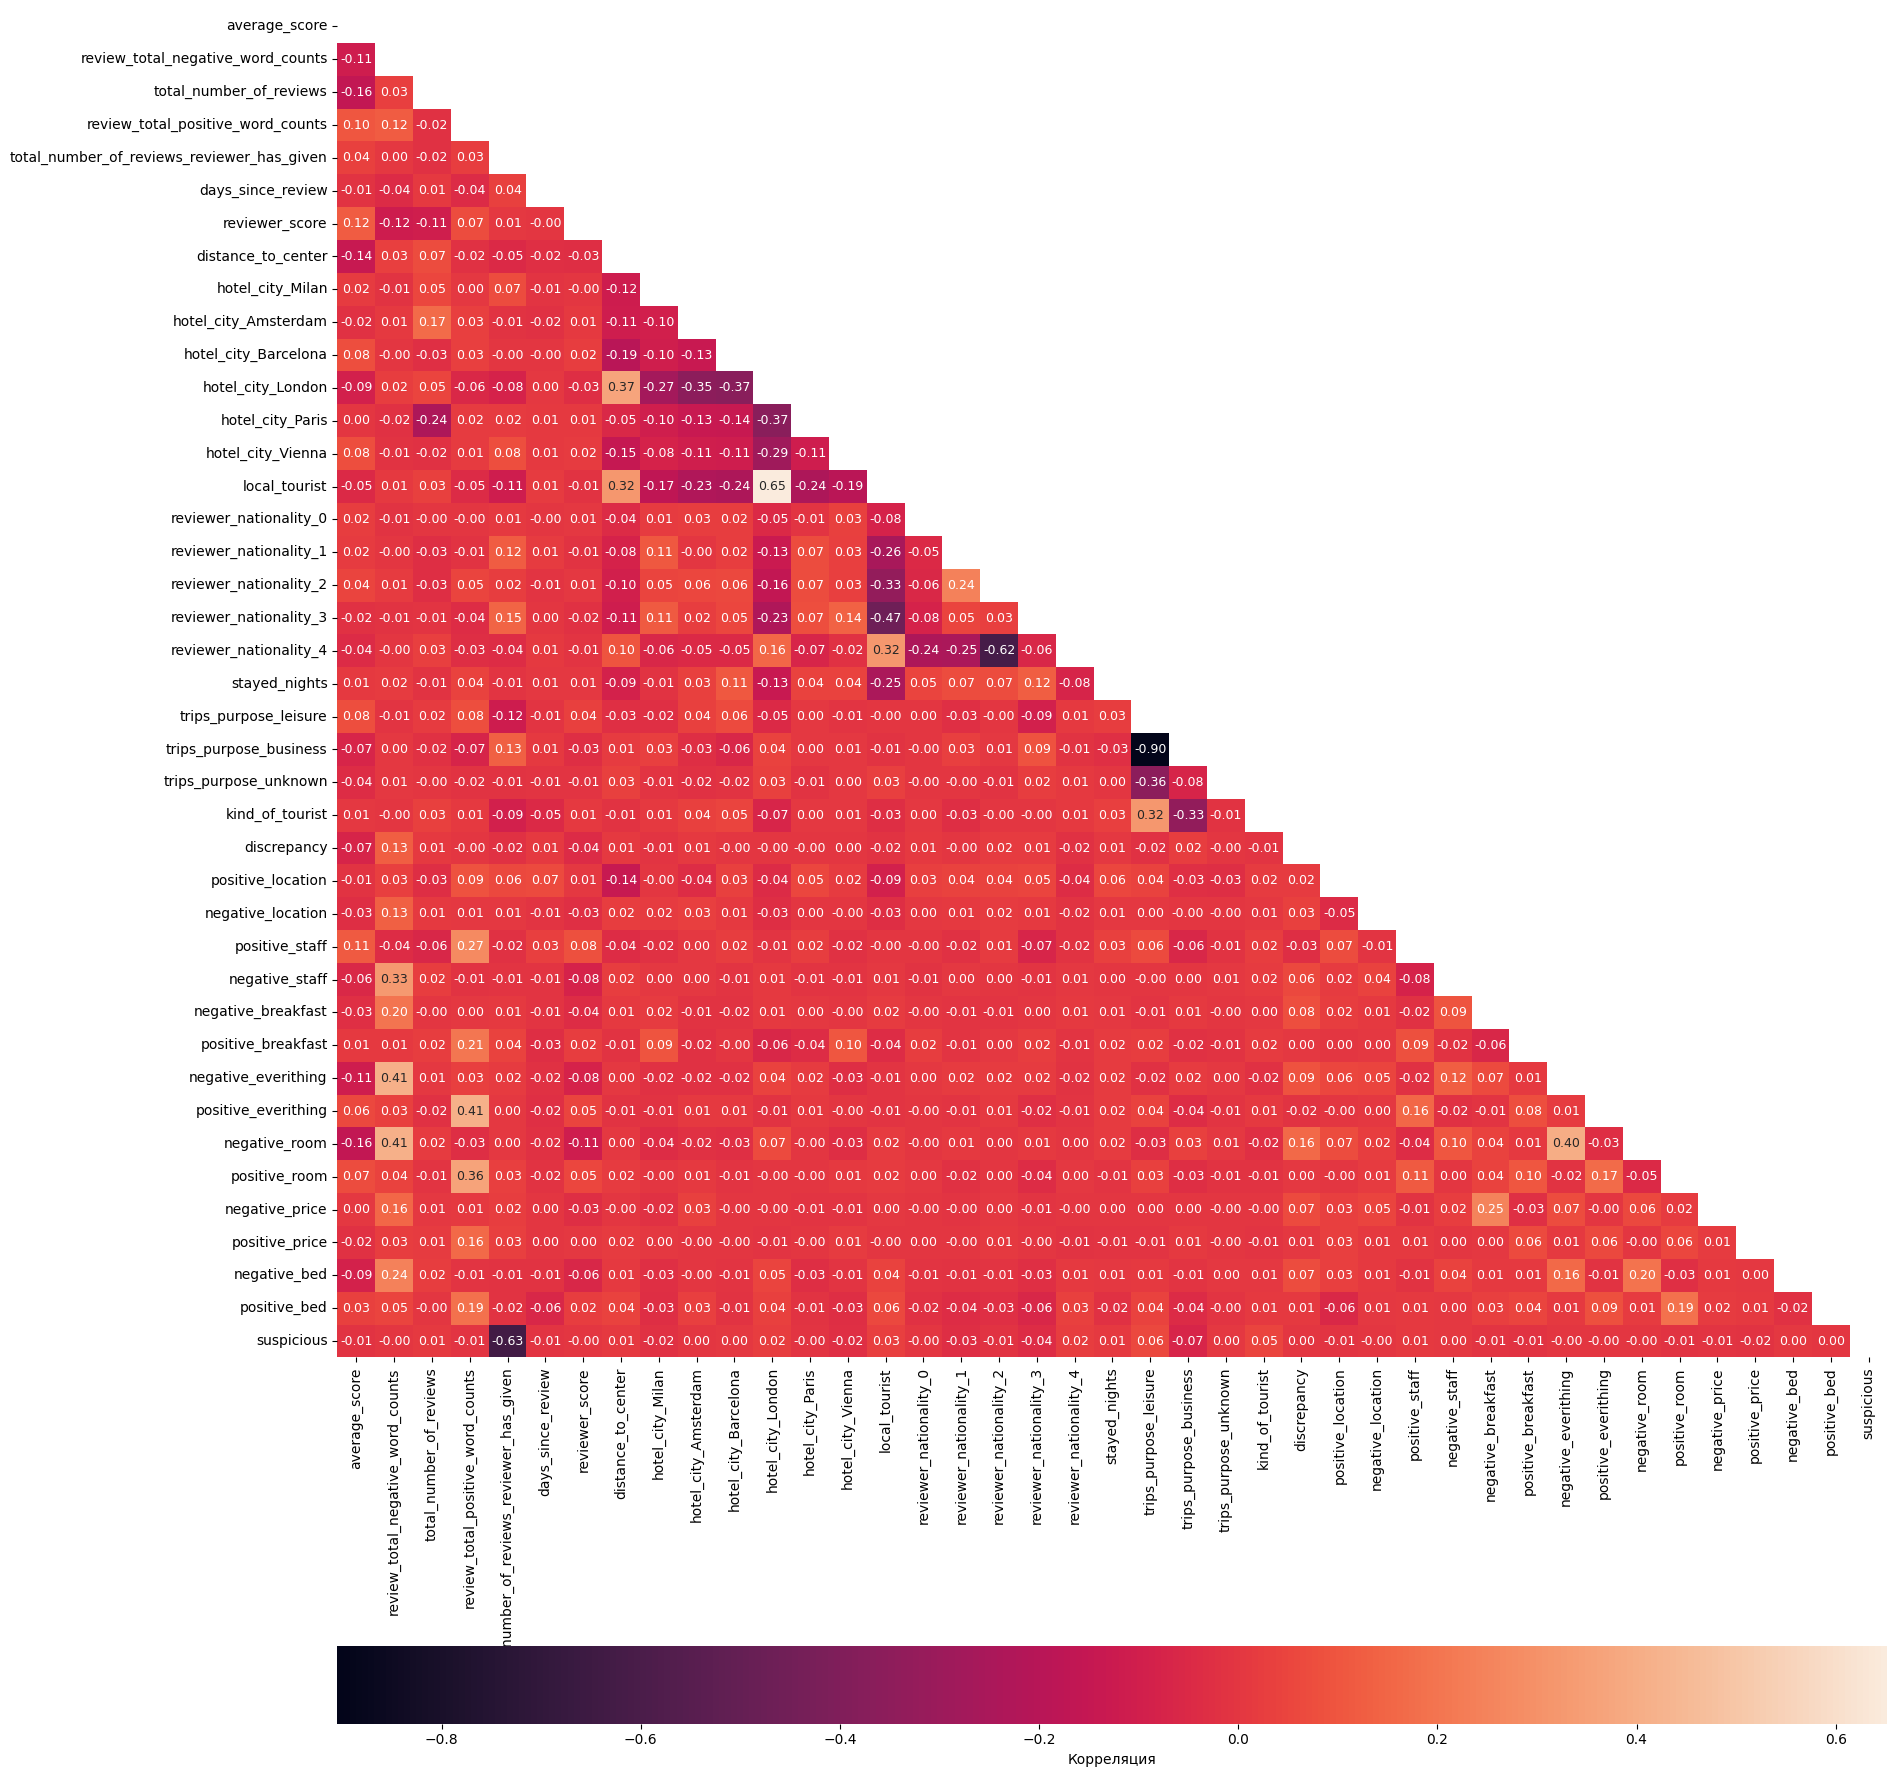

In [80]:
plt.rcParams['figure.figsize'] = (20,25)
plt.get_cmap('plasma')
half = np.triu(data.drop(['sample'], axis=1).corr())
sns.heatmap(data.drop(['sample'], axis=1).corr(), 
            annot=True, mask=half, cbar_kws={'label':'Корреляция', 'orientation': 'horizontal'},
            linecolor='white',linewidths=0, fmt='.2f',annot_kws={'size': 9}
           )

Есть скоррелированные признаки. Но suspicious создан на основе количества отзывов, которые дал рецензент ранее. Удаление trips_purpose_bisness приводит к ухудшению метрики. Мультиколлинеарность локальных туристов (local_tourist) и страны отеля - Лондон, объясняется подавляющим большинством туристов именно из Лондона в самом датасете (более 45%), логично, что и туристов оотдыхающих локально в Великобритании будет больше. Поэтому удалять ничего не буду.

In [81]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 489657 entries, 0 to 489656
Data columns (total 42 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               489657 non-null  float64
 1   review_total_negative_word_counts           489657 non-null  int64  
 2   total_number_of_reviews                     489657 non-null  int64  
 3   review_total_positive_word_counts           489657 non-null  int64  
 4   total_number_of_reviews_reviewer_has_given  489657 non-null  int64  
 5   days_since_review                           489657 non-null  int64  
 6   sample                                      489657 non-null  int64  
 7   reviewer_score                              489657 non-null  float64
 8   distance_to_center                          489657 non-null  float64
 9   hotel_city_Milan                            489657 non-null  int64  
 

In [82]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [83]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [84]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 41), (360722, 41), (360722, 40), (288577, 40), (72145, 40))

In [85]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [86]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [87]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   56.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.4s finished


In [88]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [89]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MAE: 0.8855454840945315
MAPE: 12.731031932218828


<Axes: >

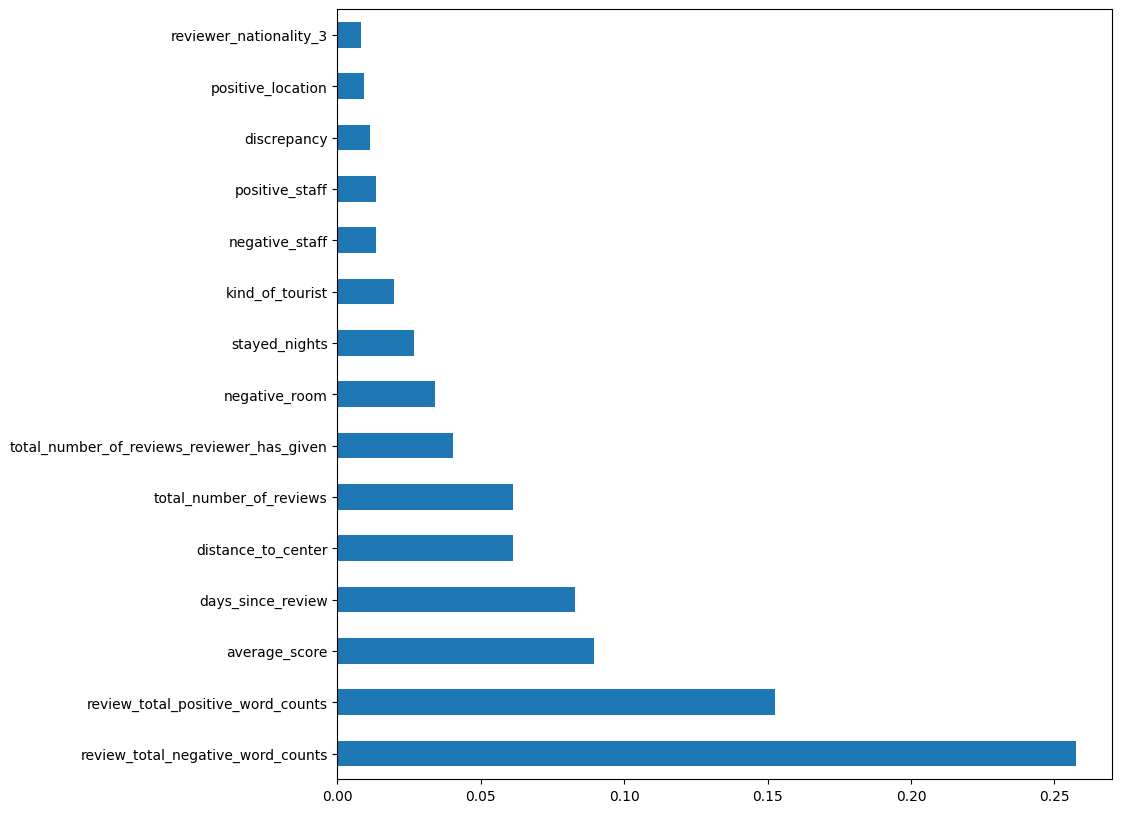

In [90]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [91]:
test_data.sample(10)

,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,reviewer_score,distance_to_center,hotel_city_Milan,hotel_city_Amsterdam,...,positive_breakfast,negative_everithing,positive_everithing,negative_room,positive_room,negative_price,positive_price,negative_bed,positive_bed,suspicious
9498,8.2,25,2665,31,2,654,0.0,0.05768,0,0,...,0,0,1,0,1,0,0,0,0,1
38008,7.8,10,2501,7,1,0,0.0,0.04025,0,1,...,0,0,1,0,0,0,0,0,1,1
102987,8.3,49,776,50,15,635,0.0,0.01402,0,0,...,0,0,0,1,0,1,1,1,0,1
41894,9.2,2,171,7,3,718,0.0,0.04381,0,0,...,0,0,1,0,0,0,0,0,0,1
71786,8.1,36,1918,15,1,487,0.0,0.00552,0,0,...,1,1,1,1,0,0,0,0,0,1
127736,7.8,5,2147,7,4,13,0.0,0.06829,0,0,...,0,0,0,0,0,0,0,0,1,1
89807,8.2,9,67,2,1,290,0.0,0.04921,0,0,...,0,0,0,0,0,0,0,0,0,1
9345,8.1,0,9568,29,13,269,0.0,0.00551,0,0,...,0,0,1,0,1,0,0,0,1,1
65745,8.5,0,3980,7,1,234,0.0,0.03136,0,0,...,0,0,0,0,0,0,0,0,1,1
39334,9.1,9,303,62,21,196,0.0,0.06037,0,0,...,0,0,1,0,1,0,0,0,1,1


In [92]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [93]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [94]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.8s finished


In [95]:
predict_submission

array([8.671, 7.031, 8.252, ..., 8.103, 9.428, 7.212])

In [96]:
list(sample_submission)

['reviewer_score', 'id']

In [97]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.671,488440
1,7.031,274649
2,8.252,374688
3,9.698,404352
4,9.543,451596
5,8.730,302161
6,7.698,317079
7,7.412,13963
8,8.637,159785
9,8.027,195089
